In this notebook we will study the energy conservation properties of several high-order methods for the Hénon–Heiles system. We will se how the energy error behaves at very thight tolerances and how different techniques such as using symplectic solvers or manifold projections benchmark against each other.
The Hamiltonian for this system is given by:
$$
\mathcal{H}=\frac{1}{2}(p_1^2 + p_2^2) + \frac{1}{2}\left(q_1^2 + q_2^2 + 2q_1^2 q_2 - \frac{2}{3}q_2^3\right)
$$

In [1]:
using DifferentialEquations, Plots
pyplot()

@inline V(q1, q2) = 1//2 * (q1^2 + q2^2 + 2q1^2 * q2 - 2//3 * q2^3)
@inline T(p1, p2) = 1//2 * (p1^2 + p2^2)
@inline H(q1, q2, p1, p2) = T(p1, p2) + V(q1, q2)

function HamiltonEqs_q(t, q, p, dq)
    dq[1] = p[1]
    dq[2] = p[2]
end

function HamiltonEqs_p(t, q, p, dp)
    dp[1] = -q[1] * (1 + 2q[2])
    dp[2] = -q[2] - (q[1]^2 - q[2]^2)
end

henon = @ode_def_noinvjac HamiltonEqs begin
    dq1 = p1
    dq2 = p2
    dp1 = -q1 * (1 + 2q2)
    dp2 = -q2 - (q1^2 - q2^2)
end

q0 = [0.1, 0.]
p0 = [0., 0.5]
u0 = hcat(q0, p0)
E = H(u0[1],u0[2],u0[3],u0[4])

function g(u, resid)
    resid[1] = H(u[1],u[2],u[3],u[4]) - E
    resid[2:4] .= 0
end

cb = ManifoldProjection(g, nlopts=Dict(:ftol=>1e-13));

INFO: Recompiling stale cache file /home/user/.julia/lib/v0.6/LearnBase.ji for module LearnBase.
INFO: Recompiling stale cache file /home/user/.julia/lib/v0.6/DifferentialEquations.ji for module DifferentialEquations.


For the comparison we will use the following function

In [2]:
function compare(; tmax=1e2, maxiters=1e10)
    prob1 = ODEProblem(henon, u0, (0., tmax))
    prob2 = DynamicalODEProblem{true}(HamiltonEqs_q, HamiltonEqs_p, q0, p0, (0., tmax))
    @time sol1 = solve(prob1, Vern9(), callback=cb, abstol=1e-14, reltol=1e-14, maxiters=maxiters);
    @time sol2 = solve(prob2, KahanLi8(), dt=1e-2, maxiters=maxiters);
    @time sol3 = solve(prob2, Vern9(), abstol=1e-14, reltol=1e-14, maxiters=maxiters);
    @time sol4 = solve(prob2, DPRKN12(), abstol=1e-14, reltol=1e-14, maxiters=maxiters);
    
    println("Vern9 + ManifoldProjection max energy error: ", maximum(abs.(map(u->H(u[1],u[2],u[3],u[4]), sol1.u) .- E)))
    println("KahanLi8 max energy error: ",                   maximum(abs.(map(u->H(u[1],u[2],u[3],u[4]), sol2.u) .- E)))
    println("Vern9 max energy error: ",                      maximum(abs.(map(u->H(u[1],u[2],u[3],u[4]), sol3.u) .- E)))
    println("DPRKN12 max energy error: ",                    maximum(abs.(map(u->H(u[1],u[2],u[3],u[4]), sol4.u) .- E)))
    
    plot(xlabel="t", ylabel="Energy error")
    plot!(sol1.t, map(u->H(u[1],u[2],u[3],u[4]), sol1.u) .- E, label="Vern9 + ManifoldProjection")
    plot!(sol2.t, map(u->H(u[1],u[2],u[3],u[4]), sol2.u) .- E, label="KahanLi8")
    plot!(sol3.t, map(u->H(u[1],u[2],u[3],u[4]), sol3.u) .- E, label="Vern9")
    plot!(sol4.t, map(u->H(u[1],u[2],u[3],u[4]), sol4.u) .- E, label="DPRKN12")
end

compare (generic function with 1 method)

Note: The `NLsolve` call used by `ManifoldProjection` was modified to use `ftol=1e-13` in order to obtain a very low energy error. 

  0.019887 seconds (63.22 k allocations: 8.403 MiB, 56.62% gc time)
  0.013071 seconds (190.21 k allocations: 10.319 MiB)
  0.039839 seconds (1.58 M allocations: 26.838 MiB, 37.22% gc time)
  0.000695 seconds (9.00 k allocations: 408.094 KiB)
Vern9 + ManifoldProjection max energy error: 5.551115123125783e-16
KahanLi8 max energy error: 4.9404924595819466e-15
Vern9 max energy error: 1.4988010832439613e-15
DPRKN12 max energy error: 2.220446049250313e-15



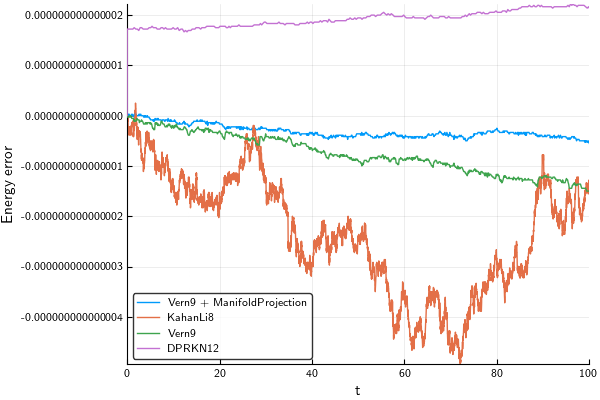

In [4]:
compare(tmax=1e2)

Because the energy error for the `Vern9` method is lower than the tolerance for `NLsolve`, this method and the `ManifoldProjection` version produce identical results.

  0.106677 seconds (625.30 k allocations: 83.585 MiB, 30.53% gc time)
  0.290053 seconds (1.90 M allocations: 101.091 MiB, 55.82% gc time)
  0.857925 seconds (15.78 M allocations: 267.808 MiB, 71.58% gc time)
  0.005751 seconds (82.57 k allocations: 3.604 MiB)
Vern9 + ManifoldProjection max energy error: 5.578870698741412e-15
KahanLi8 max energy error: 1.815214645262131e-14
Vern9 max energy error: 1.3933298959045715e-14
DPRKN12 max energy error: 3.1363800445660672e-15



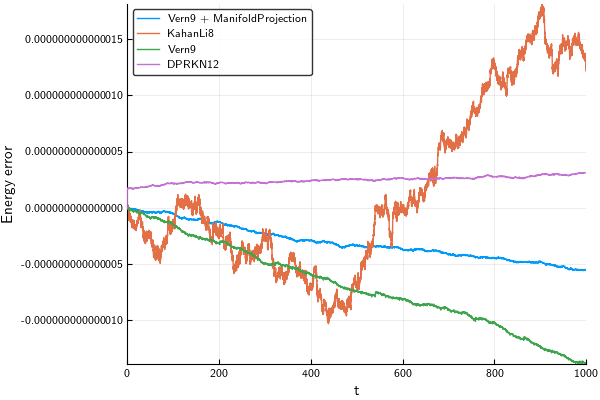

In [8]:
compare(tmax=1e3)

  2.256525 seconds (6.25 M allocations: 832.985 MiB, 70.12% gc time)
  2.624151 seconds (19.00 M allocations: 966.797 MiB, 51.25% gc time)
 12.414428 seconds (157.84 M allocations: 2.613 GiB, 72.91% gc time)
  0.092486 seconds (819.28 k allocations: 35.250 MiB, 35.57% gc time)
Vern9 + ManifoldProjection max energy error: 4.50195436485501e-14
KahanLi8 max energy error: 3.1585845050585704e-14
Vern9 max energy error: 1.22291066162461e-13
DPRKN12 max energy error: 1.607047828144914e-14



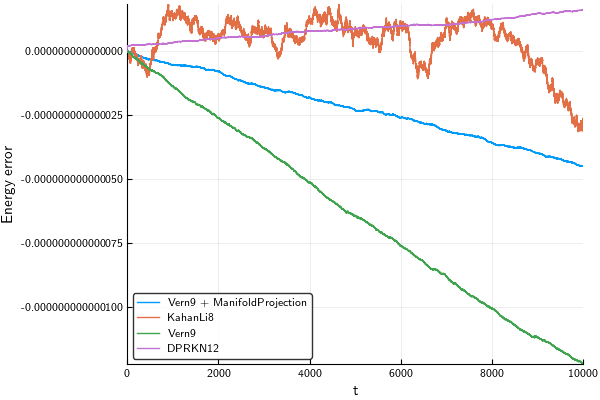

In [10]:
compare(tmax=1e4)

 12.994881 seconds (31.24 M allocations: 4.042 GiB, 72.56% gc time)
 22.337958 seconds (95.00 M allocations: 4.799 GiB, 72.33% gc time)
181.428361 seconds (789.20 M allocations: 13.041 GiB, 92.37% gc time)
  6.046755 seconds (4.09 M allocations: 178.146 MiB, 95.27% gc time)
Vern9 + ManifoldProjection max energy error: 9.997558336749535e-14
KahanLi8 max energy error: 1.2331802246023926e-13
Vern9 max energy error: 5.982436768192656e-13
DPRKN12 max energy error: 6.242228955954943e-14



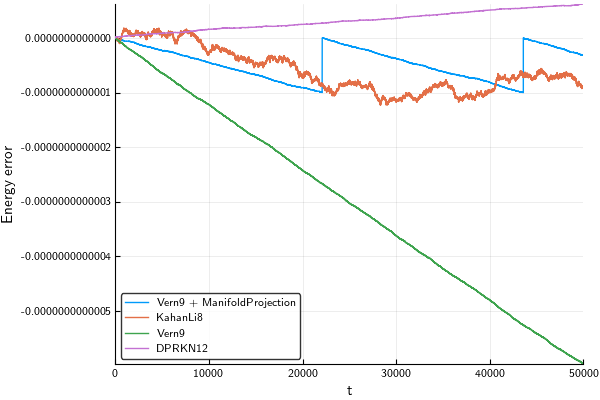

In [11]:
compare(tmax=5e4)

We can see that as the simulation time increases, the energy error increases. For this particular example the energy error for all the methods is comparable, but for smaller simulation times, if a highly accurate solution is required, the symplectic method is not recommended as its energy error fluctuations are relatively larger.
The above plot shows how the `Vern9` method and the `ManifoldProjection` version start to differ exactly when the energy error reaches the chosen tolerance for `NLsolve` (`ftol=1e-13`).